In [813]:
import pandas as pd
import numpy as np
from scipy import optimize
import os
import json
from matplotlib import pyplot as plt
import matplotlib
import pickle as pkl

from collections import defaultdict

In [2]:
param_names = [
                 'num_trains',
                 'qf_lr',

               ]
param_full_names = [
                 'algorithm_args/num_trains_per_train_loop',
                 'qf_lr',

                    ]
result_names = [
                'expl_num_correct',
                'expl_successes',
                'expl_noop',

                'qf_loss',
                'Q_values_mean',
                'Q_values_std',

                ]
result_full_names = [
                     'exploration/env_infos/num_correct_Mean',
                     'exploration/env_infos/final/task_success_Mean',
                     'exploration/env_infos/noop_Mean',
                    'trainer/QF_Loss',
                    'trainer/Q_Predictions_Mean',
                    'trainer/Q_Predictions_Std',
                    ]


In [814]:
class Reader:
    def read_csv(self,paths,name='pretrain.csv'):
        dfs = []
        for path in paths:
            try:
                df = pd.read_csv(os.path.join(path,name))
                dfs.append(df)
            except:
                continue
        return dfs
    
    def read_pkl(self, paths, name='metrics.pkl'):
        data = []
        for path in paths:
            try:
                with open(os.path.join(path, name), 'rb') as f:
                    data.append(pkl.load(f))
            except:
                continue
        return data
    
def smooth(x):
    return np.convolve(x, np.ones(window), 'valid') / window

def plot(dfs, metric, index_sets):
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        for indices, label in index_sets:
            indices = [index for index in indices if index < len(dfs)]
            data = [smooth(dfs[i][metric]) for i in indices if metric in dfs[i].keys()]
            min_len = min([len(x) for x in data])
            data = [x[:min_len] for x in data]
            if len(data) > 0:
                std_error = np.std(data, axis=0) / np.sqrt(len(indices)) 
                mean = np.mean(data, axis=0)
                plt.plot(mean, label=label)
                plt.fill_between(np.arange(len(mean)), mean-std_error, mean+std_error, alpha=0.1)
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.legend()


def get_dfs(tests):
    paths = []
    for test in tests:
        root_path = os.path.join(os.path.abspath(''),'logs',test,)
        test_paths = [os.path.join(root_path, run) for run in os.listdir(root_path)]
        test_paths = sorted(test_paths)
        paths.extend(test_paths)

    dfs = Reader().read_csv(paths, name='progress.csv')
    for df in dfs:
        df.columns = df.columns.get_level_values(0)
    return dfs

def get_metrics(tests):
    paths = []
    for test in tests:
        root_path = os.path.join(os.path.abspath(''), 'logs', test)
        test_paths = [os.path.join(root_path, run) for run in os.listdir(root_path)]
        test_paths = sorted(test_paths)
        paths.extend(test_paths)
    
    return Reader().read_pkl(paths, name='metrics.pkl')


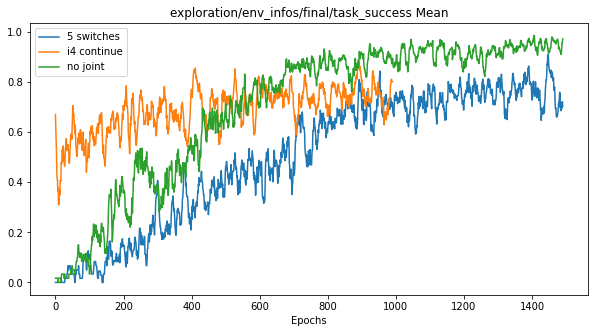

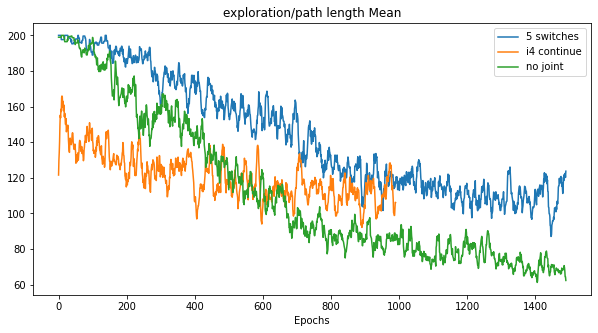

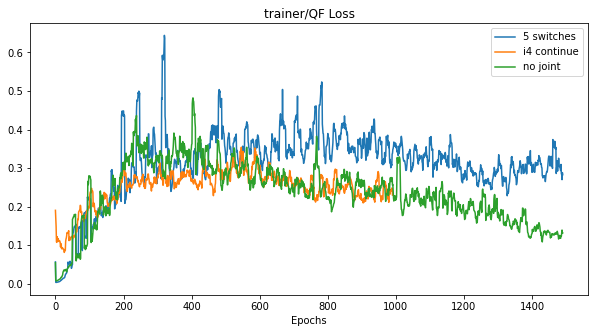

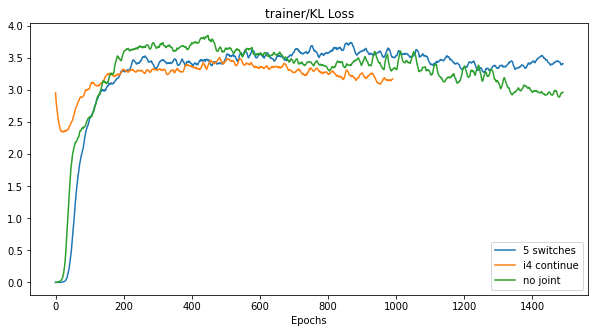

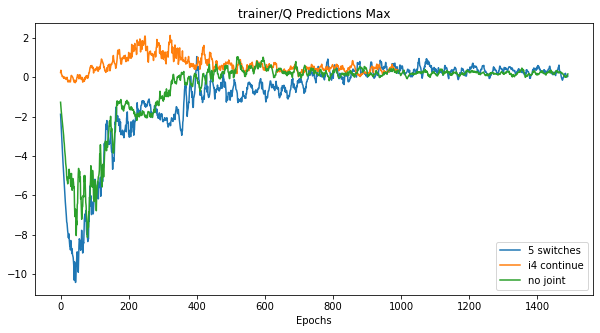

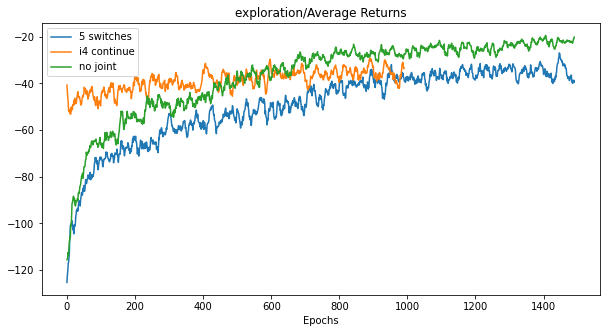

In [804]:
tests = ['pretrain-dqn']
dfs = get_dfs(tests)

# old pretrain

# i0 = [0], '5'
# i1 = [1], '5 her'
# i2 = [2], '5 her 3 targets'
# i3 = [3], 'i0 continue'
# i4 = [4], '5 her indicator'
# i5 = [5], '5 3 targets'
# i6 = [6], 'i3 (5) continue 0.2 offset'

# # not state conditioned
# i7 = [7], '5'
# i8 = [8], '5 3 targets'
# i9 = [9], 'i7 (5) continue'
# i10 = [10], 'i8 (5 3 targets) continue'

# not state conditioned, scramble goal input to decoder, non overlap
i0 = [0], '5 switches'
i1 = [1], '5 switches 3 target'

# RAD + unperturbed
i2 = [2], '5 switches'
i3 = [3], '5 switches, 3 target'

# adjusted state, overlapping
i4 = [4], '5 switches'
i5 = [5], 'i4 continue'

i6 = [6], 'no joint'

metrics = ['exploration/env_infos/final/task_success Mean', 'exploration/path length Mean',
           'trainer/QF Loss', 'trainer/KL Loss', 'trainer/Q Predictions Max', 'exploration/Average Returns']


index_sets = [i4, i5, i6]
window = 10
plot(dfs, metrics, index_sets)

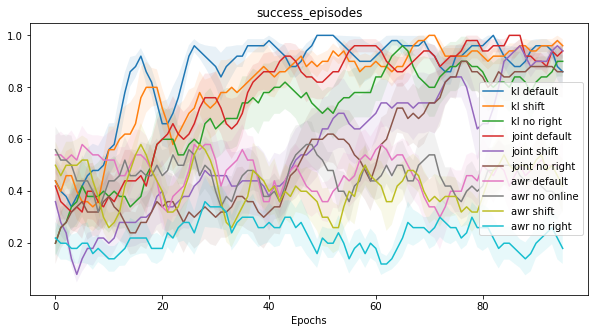

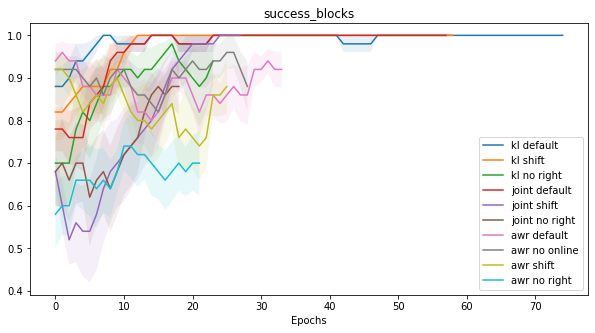

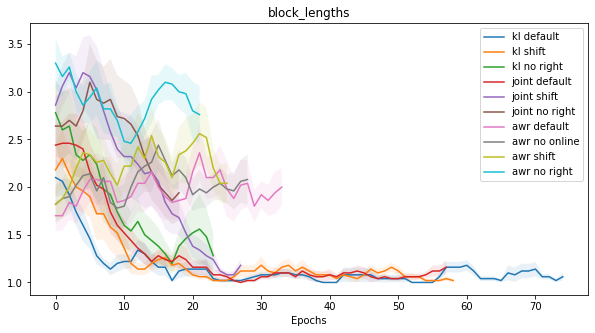

In [867]:
tests = ['calibrate-sac/']
data = get_metrics(tests)

seeds = np.arange(10)

# 100 steps per episode, 2 calibration/goal

# kl
i0 = 0 + seeds, 'kl default'
i1 = 10 + seeds, 'kl no online'
i2 = 20 + seeds, 'kl shift'
i3 = 30 + seeds, 'kl no right'

# joint
i4 = 40 + seeds, 'joint default'
i5 = 50 + seeds, 'joint no online'
i6 = 60 + seeds, 'joint shift'
i7 = 70 + seeds, 'joint no right'

# awr
i8 = 80 + seeds, 'awr default'
i9 = 90 + seeds, 'awr no online'
i10 = 100 + seeds, 'awr shift'
i11 = 110 + seeds, 'awr no right'


metrics = ['success_episodes', 'success_blocks', 'block_lengths']

index_sets = [i0, i2, i3, i4, i6, i7, i8, i9, i10, i11]
window = 5
plot(data, metrics, index_sets)


In [317]:
tests = ['pretrain-td3/']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])

paths = sorted(paths, key=lambda x: x[0])


dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
# adjusted state, overlapping
i0 = [0], '5 switches'

metrics = ['exploration/env_infos/final/task_success Mean', 'exploration/path length Mean', 'trainer/SL Loss',
           'trainer/Latent Error', 'trainer/Gradient Norm']

index_sets = [i0]
window = 10
plot(dfs, metrics)

TypeError: plot() missing 1 required positional argument: 'index_sets'

3


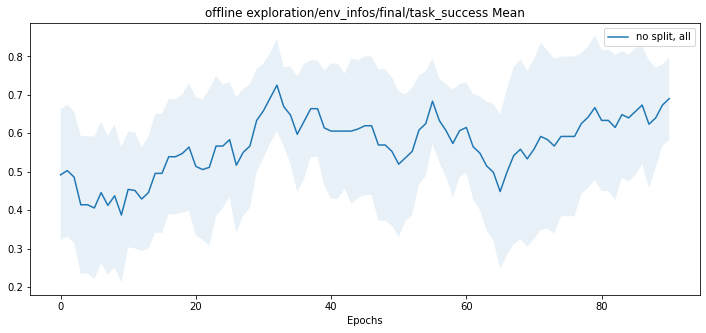

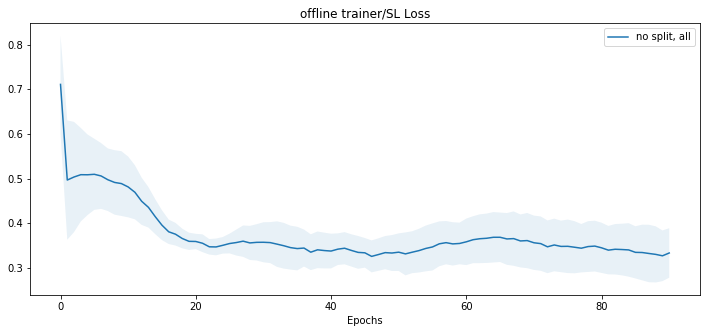

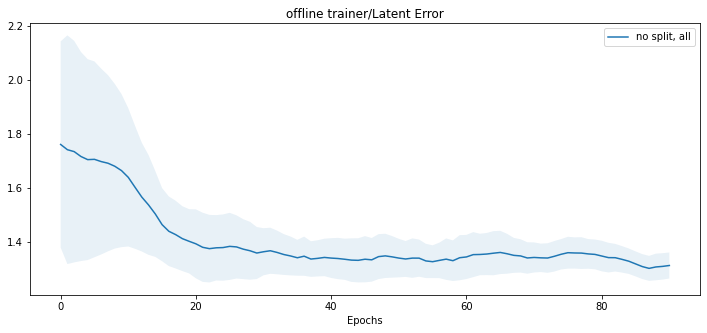

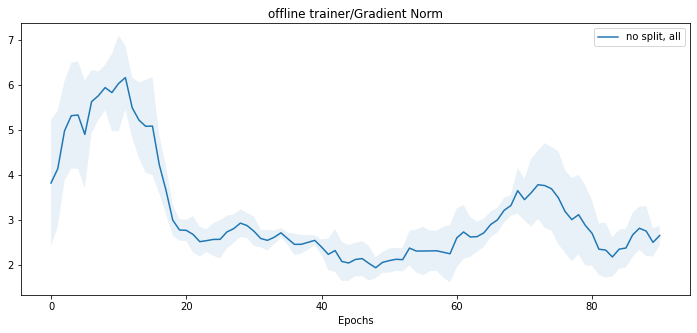

In [5]:
tests = ['calibrate-dqn']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])

paths = sorted(paths, key=lambda x: x[0])

dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
metrics = ['exploration/env_infos/final/task_success Mean', 'trainer/SL Loss',
           'trainer/Latent Error', 'trainer/Gradient Norm']

print(len(dfs))

# calibrate-dqn-5 old
# i0 = [0, 1, 2], 'sample, no split, no right'
# i1 = [3, 4, 5], 'sample, no split, no left'
# i2 = [6, 7, 8], 'sample, no split, no mid'
# i3 = [9, 10, 11], 'sample, no split, all'

# i4 = [12, 13, 14], 'sample, split, no right'
# i5 = [15, 16, 17], 'sample, split, no left'
# i6 = [18, 19, 20], 'sample, split, no mid'
# i7 = [21, 22, 23], 'sample, split, all'

# i8 = [24, 25, 26], 'sample, no split, no right'
# i9 = [27, 28, 29], 'sample, no split, no left'
# i10 = [30, 31, 32], 'sample, no split, no mid'
# i11 = [], 'sample, no split, all'

i0 = [0, 1, 2], 'no split, all'

index_sets = [i0] #[i24, i25, i26, i27, i28, i29]
window = 10
plot(dfs, metrics)

30


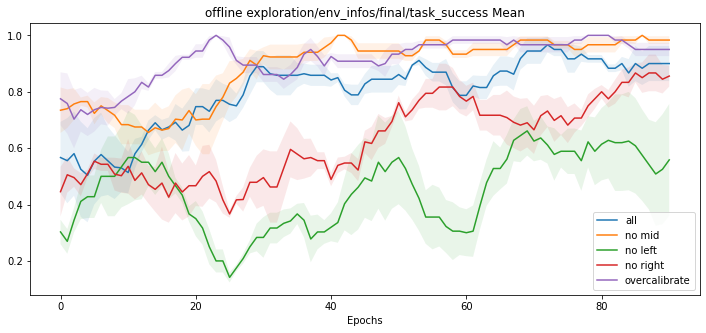

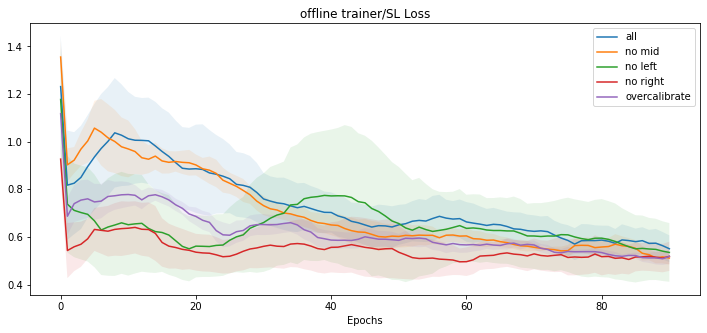

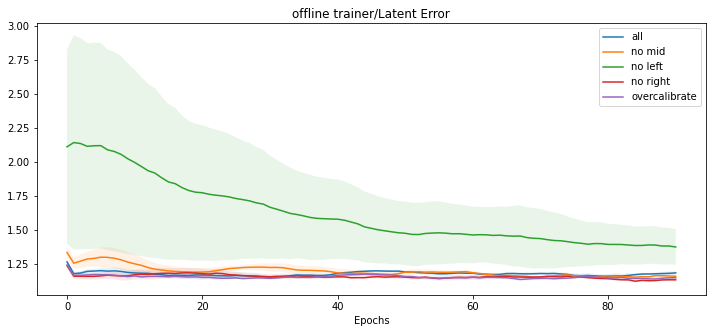

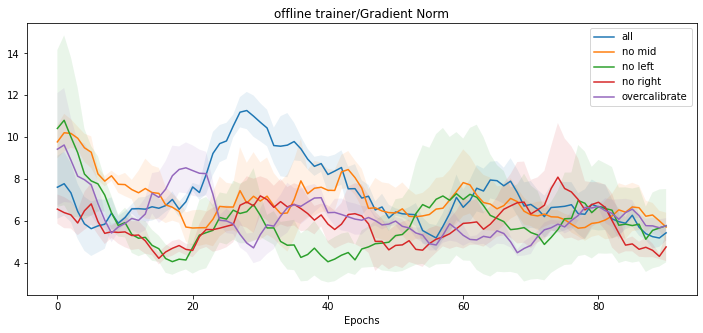

In [570]:
tests = ['calibrate-sac']

paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[])

paths = sorted(paths, key=lambda x: x[0])

dfs = Reader().read(paths, name='progress.csv')
for df in dfs:
    df.columns = df.columns.get_level_values(0)
    
metrics = [
           'exploration/env_infos/final/task_success Mean', 'trainer/SL Loss',
           'trainer/Latent Error', 'trainer/Gradient Norm']

# calibrate-sac-5 old
# i0 = [0, 1, 2], 'no shift, no right'
# i1 = [3, 4, 5], 'no shift, no left'
# i2 = [6, 7, 8], 'no shift, no mid'
# i3 = [9, 10, 11], 'no shift, all'

# i4 = [12, 13, 14], 'shift, no right'
# i5 = [15, 16, 17], 'shift, no left'
# i6 = [18, 19, 20], 'shift, no mid'
# i7 = [21, 22, 23], 'shift, all'

i0 = [0, 1, 2], 'no shift, all, 5 per'
i1 = [3, 4, 5], 'no shift, all, 1 per'

i2 = [6, 7, 8], 'no shift, no mid, 5 per'
i3 = [9, 10, 11], 'shift, all, 5 per'
i4 = [12, 13, 14], 'no shift, no left, 5 per'
i5 = [15, 16, 17], 'no shift, no left, 1 per'
i6 = [18, 19, 20], 'no shift, overcalibrate, 5 per'

i7 = [21, 22, 23], 'no shift, no right, 5 per'
i8 = [24, 25, 26], 'no shift, no right, 1 per'

i9 = [27, 28, 29], 'no shift, no right, 5 per, 5 cal/target'



print(len(dfs))

cal_all = [0, 1, 2], 'all'
no_mid = [6, 7, 8], 'no mid'
no_left = [12, 13, 14], 'no left'
no_right = [21, 22, 23], 'no right'
over = [18, 19, 20], 'overcalibrate'


index_sets = [i0, i7, i8, i9]
index_sets = [cal_all, no_mid, no_left, no_right, over]
window = 10
plot(dfs, metrics)

In [ ]:
import h5py
import torch

data = h5py.File('rl/gaze_capture/gaze_data.h5', 'r')
state = torch.load('rl/gaze_capture/checkpoint.pth.tar')['state_dict']
weights = state['fc.2.weight'].cpu().detach().numpy().T
bias = state['fc.2.bias'].cpu().detach().numpy().T
features = []
for key in data.keys():
    features.append(data[key][()][0])
    # pos = data[key][()] @ weights + bias
    # plt.scatter(pos[:, 0], pos[:, 1], label=key)
#plt.legend()
for i, f1 in enumerate(features):
    for f2 in features[i + 1:]:
        print(np.linalg.norm(f1 - f2))

In [ ]:
from rlkit.util.io import load_local_or_remote_file
from mpl_toolkits.mplot3d import Axes3D

rl_gaze = h5py.File('rl/gaze_capture/gaze_data_rl.h5', 'r')

gaze_demo_path = 'demos/int_OneSwitch_sim_gaze_on_policy_100_all_debug_1615418204600284881.npy'
gaze_demos = load_local_or_remote_file(gaze_demo_path)
gaze = [[], [], []]
for path in gaze_demos:
    target = np.where(path['env_infos'][1]['target_string'] == 0)[0][0]
    gaze[target].append(path['observations'][1][-128:])
    
pos_path = 'demos/int_OneSwitch_sim_goal_model_on_policy_1000_all_debug_1615835470059229510.npy'
pos_demos = load_local_or_remote_file(pos_path)
pos = [[], [], []]
for path in pos_demos[:100]:
    target = np.where(path['env_infos'][1]['target_string'] == 0)[0][0]
    pos[target].append(path['observations'][1][-128:-125])
pos = [np.array(x) for x in pos]
    
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_12_27_01_0000--s-0/pretrain.pkl'
#discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_14_39_16_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_15_14_54_25_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/bc-mixed/bc_mixed_2021_03_16_21_52_57_0000--s-0/pretrain.pkl'
discrim_policy_path = 'logs/sparse-mixed/sparse_mixed_2021_03_15_21_16_50_0000--s-0/pretrain.pkl'
#discrim_policy_path = 'logs/sparse-mixed/sparse_mixed_2021_03_17_14_09_47_0000--s-0/pretrain.pkl'


policy = torch.load(discrim_policy_path, map_location=torch.device("cpu"))


fig = plt.figure()
#ax = Axes3D(fig)

# for key in rl_gaze.keys():
for i in range(3):
    rl = rl_gaze[str(i)][()]
    rl_pred = 0
    gaze_pred = 0

#     encoders = policy['qf'].gaze_encoders
#     for encoder in encoders:
#         rl_pred += encoder(torch.Tensor(rl)).detach().numpy()
#         gaze_pred += encoder(torch.Tensor(gaze[i])).detach().numpy()
        
    encoder = policy['qf'].gaze_encoder
    
    
#     for encoder in policy.gaze_encoders:
#         rl_pred += encoder(torch.Tensor(rl)).detach().numpy()
#         gaze_pred += encoder(torch.Tensor(gaze[i])).detach().numpy()
        
#    rl_pred /= policy['qf'].num_encoders
#    gaze_pred /= policy['qf'].num_encoders
    rl_pred = encoder(torch.Tensor(rl)).detach().numpy()
    gaze_pred = encoder(torch.Tensor(gaze[i])).detach().numpy()
    #ax.scatter(rl_pred[..., 0], rl_pred[..., 1], rl_pred[..., 2])
    #ax.scatter(gaze_pred[..., 0], gaze_pred[..., 1], gaze_pred[..., 2])
    #ax.scatter(pos[i][:, 0], pos[i][:, 1], pos[i][:, 2])
    #plt.scatter(rl_pred[..., 0], rl_pred[..., 1])
    plt.scatter(gaze_pred[..., 0], gaze_pred[..., 1])
    plt.scatter(pos[i][:, 0], pos[i][:, 1])



In [ ]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(15,5))
axs = axs.flatten()
idx = pd.IndexSlice
test_name_map = {'experiment2-laptop-dqn':'dqn','experiment2-laptop-sac':'sac',
                 'experiment2-laptop-dqn-cql':'cql-dqn','experiment2-laptop-cql':'cql-sac',}
metric_name_map = {'expl_successes':'Success Rate','expl_noop': 'User Noop Rate'}

# slice_df = slice_df.drop(columns=[(5e-4,1e-2),(1e-3,1e-2)])
# print(slice_df.head())


for (name,alpha),ax in zip(alphas.items(),axs):
#     try:
        mean_graph = df_mean.loc[:,idx[:,:,:,:,name]]
        std_graph = df_std.loc[:,idx[:,:,name]]
#         graph_df = df.loc[:,[(.001,.1,.1,name),(.001,1,.3,name)]]

#         graph_df = graph_df.drop(columns=[(1e-3,5e-5,1e-2)])
        mean_graph.columns = mean_graph.columns.droplevel([c for c in mean_graph.columns.names
                                                           if mean_graph.columns.get_level_values(c).unique().size == 1])
        mean_graph = mean_graph.ewm(alpha=alpha).mean()
        std_graph.columns = std_graph.columns.droplevel([c for c in std_graph.columns.names
                                                         if std_graph.columns.get_level_values(c).unique().size == 1])
        std_graph = std_graph.ewm(alpha=alpha).mean()
        for (col_names,mean),(_col_names,std) in zip(mean_graph.iteritems(),std_graph.iteritems()):
            ax.fill_between(x=range(mean.size),y1=np.maximum(0,mean-std),y2=np.minimum(1,mean+std),alpha=.3)
            ax.plot(range(mean.size),mean,label=f"({not col_names[0]},{test_name_map[col_names[1]]})")
        ax.set_title(metric_name_map[name])
        ax.set_xlabel("Epochs")
#         ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
        ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
#     except:
#         continue

# plt.savefig('experiment2_laptop_full.png')

In [47]:
defaults = { demo[-17:-4]:np.load(os.path.join(os.path.abspath(''),'demos',demo),allow_pickle=True)
             for demo in os.listdir(os.path.join(os.path.abspath(''),"demos")) if f"thr_" in demo and "OneSwitch" in demo}
# defaults = [np.load(os.path.join(os.path.abspath(''),'demos',f"LightSwitch_usermodel_1001.npy"),allow_pickle=True)]

In [48]:
defaults.keys()

dict_keys(['thr_.5_eps_50', 'thr_.5_eps_25', '_thr_.5_eps_0', '_thr_.0_eps_0', '_thr_.2_eps_0'])

In [49]:
success = {key:np.mean([path['env_infos'][-1]['task_success'] for path in paths])
           for key,paths in defaults.items()}
bad_contact = {key:np.mean([path['env_infos'][-1]['bad_contact'] for path in paths])
           for key,paths in defaults.items()}
noop = {key:np.mean(sum([[info['noop'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}
cos = {key:np.mean(sum([[info['cos_error'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}

In [50]:
success

{'thr_.5_eps_50': 1.0,
 'thr_.5_eps_25': 1.0,
 '_thr_.5_eps_0': 1.0,
 '_thr_.0_eps_0': 1.0,
 '_thr_.2_eps_0': 0.99375}

In [51]:
noop

{'thr_.5_eps_50': 0.5710240436595788,
 'thr_.5_eps_25': 0.6327110825018775,
 '_thr_.5_eps_0': 0.6814617849594328,
 '_thr_.0_eps_0': 0.7638537347191556,
 '_thr_.2_eps_0': 0.7429401323220913}

In [22]:
params_2_test = defaultdict(list)

for path in paths:
    test_name = os.path.split(os.path.split(path)[0])[1]     

    params = []
    with open(os.path.join(path,'variant.json'),) as f:
        all_params = json.load(f) 
    for name,full_name in zip(param_names,param_full_names):
        param = all_params
        for key in full_name.split('/'):
            param = param.get(key,0)
        params.append(param)
    params = tuple(params)
    params_2_test[params].append(test_name)
    

TypeError: expected str, bytes or os.PathLike object, not tuple

In [32]:
params_2_test

defaultdict(list,
            {(1000,): ['run1', 'run0', 'run4'],
             (1,): ['run5', 'run2', 'run3']})

In [67]:
trajs = [np.load(os.path.join(os.path.abspath(''),'eval_paths1',f"{run[3:]}_eval_paths.npy"),allow_pickle=True)
             for run in ['run14']]

In [68]:
print(len(trajs[0]))

18


In [85]:
pos = sum([[tr['observations'][:,-20:-17] for tr in traj[:40]] for traj in trajs],[])
pos1 = pos[0]
mean_pos = np.mean(pos1,axis=0)
max_extent = np.max(np.linalg.norm(pos1-mean_pos,axis=1))
pos1 = (pos1-mean_pos)/max_extent

pos2 = pos[1]
mean_pos = np.mean(pos2,axis=0)
max_extent = np.max(np.linalg.norm(pos2-mean_pos,axis=1))
pos2 = (pos2-mean_pos)/max_extent

# pos = np.mean(pos,axis=0)
reg_pos = []
for traj in pos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    reg_pos.append(traj)
pos = np.array([np.mean([sample[i] for sample in reg_pos if len(sample) > i],axis=0) for i in range(200)])


NameError: name 'trajs' is not defined

In [70]:
# a = .15
# b = .3
# c = .6

In [71]:
dpos = [tr['observations'][:,-20:-17] for tr in defaults[0]]
dpos1 = dpos[0]
mean_pos = np.mean(dpos1,axis=0)
max_extent = np.max(np.linalg.norm(dpos1-mean_pos,axis=1))
dpos1 = (dpos1-mean_pos)/max_extent

dreg_pos = []
for traj in dpos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    dreg_pos.append(traj)
dpos = np.array([np.mean([sample[i] for sample in dreg_pos if len(sample) > i],axis=0) for i in range(200)])


In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

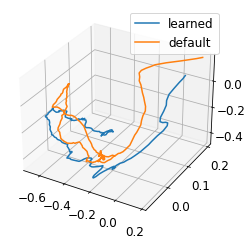

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos)),label='learned')
ax.plot(*list(zip(*dpos)),label='default')
ax.legend()

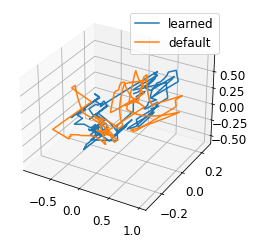

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos1)),label='learned')
ax.plot(*list(zip(*dpos1)),label='default')
ax.legend()

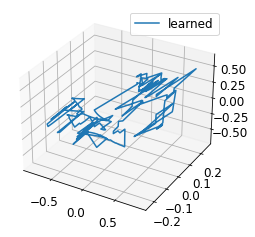

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos2)),label='learned')
# ax.plot(*list(zip(*dpos2)),label='default')
ax.legend()